# Demo RNA  usando Auto-Keras para procesar imágenes e identificar la clase que corresponde
Fuente:https://autokeras.com/

( *No se usa GPU porque tira error de memoria * )

0) Preparar ambiente:

In [1]:
#@title Instalar Auto-Keras 
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras


     |████████████████████████████████| 98 kB 4.7 MB/s 
     |████████████████████████████████| 166 kB 14.0 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 454.4 MB 21 kB/s 
     |████████████████████████████████| 462 kB 63.4 MB/s 
     |████████████████████████████████| 4.0 MB 69.9 MB/s 
     |████████████████████████████████| 1.2 MB 54.8 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=dd79013a96fc03bcc223f5f0aed17a5712e0643096f50f5725b244e07f2ad23e
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio

1) Cargar librerías:

In [2]:
#@title Librerías a usar
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Definir los parámetros:

In [3]:
## selección de los parámetros 

# 
#@markdown ### Parámetros de imágenes:
imagen_largo_ancho = 32 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
imagen_usar_generadas_data_augmentation = True #@param {type:"boolean"}


## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = False


print ("Tamaño Imagen: ", IMAGE_SHAPE)

Tamaño Imagen:  (32, 32, 3)


3) Montar el Drive:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/IRIS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

> Para Entrenamiento: 
- Clases cargadas:  57
- Imágenes cargadas:  57
- Ejemplo  versicolor   (32, 32, 3) : 


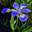



> Para Prueba: 
- Clases cargadas:  33
- Imágenes cargadas:  33
- Ejemplo  virginica   (32, 32, 3) : 


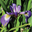

In [5]:
#@title Cargar imágenes
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (57, 32, 32, 3)
 - y_train (cant):  57


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (33, 32, 32, 3)
 - y_test (cant):  33


> Para Ambos: 
 - dictMapeo:  {'versicolor': 0, 'setosa': 1, 'virginica': 2}
 - clases_map:  ['versicolor', 'setosa', 'virginica']

 - Imagen reconstruida de  versicolor ( 0  /  [1. 0. 0.] )


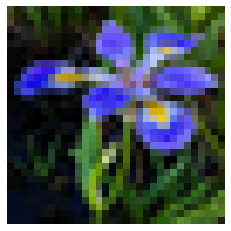

In [6]:
#@title Preparar imágenes
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))  
  return auxiAr
  
# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
if tipo_output_softMax:
  print(" - y_trainEnc (cant): ", len(y_trainEnc))
else:
  print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
if tipo_output_softMax:
  print(" - y_testEnc (cant): ", len(y_testEnc))
else:
  print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

5) Establecer el modelo para la RNA:

In [22]:
#@title Establecer modelo base para AutoKeras

tipo_modelo_usar = "Personalizado" #@param ["ImageClassifier", "Personalizado"]

cantidad_intentos_encontrar_modelo = 5 #@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1

max_cant_params_modelo =  50000000#@param {type:"integer"}
if max_cant_params_modelo <= 0:
  max_cant_params_modelo = None
#@markdown   --- Nota:se limita la complejidad el modelo a usar para evitar problemas por limitación de memoria RAM ---

max_epocas_entrenamiento =  300#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None

# AutoKeras siempre se usa salida softmax 
# (se puede usar salida lineal pero lo aplica el pipeline,
#  no el modelo que se exporta)
tipo_output_softMax = True

if tipo_modelo_usar == "ImageClassifier":
    # Initialize the image classifier.
    AKmodel = ak.ImageClassifier(num_classes=len(clases_map), 
                                          overwrite=True, 
                                          seed=1,
                                          objective='val_accuracy',
                                          max_model_size=max_cant_params_modelo,
                                          max_trials=cantidad_intentos_encontrar_modelo)
else:
    # capa de entrada
    input_node = ak.ImageInput()
    # capas intermedias
    output_node = ak.ImageBlock(
        # Only search ConvNet architectures.
        block_type="vanilla",
        # Normalize the dataset.
        normalize=True,
        # Allow do data augmentation.
        augment=True,
    )(input_node)
    # capa de salida
    output_node = ak.ClassificationHead(num_classes=len(clases_map))(output_node)
    # Initialize AutoModel personalizado
    AKmodel = ak.AutoModel(
        inputs=input_node, outputs=output_node,          
        overwrite=True, 
        seed=1,
        objective='val_accuracy',
        max_model_size=max_cant_params_modelo,
        max_trials=cantidad_intentos_encontrar_modelo)

print("Modelo preparado")


Modelo preparado


6) Entrenar el modelo de la RNA:

In [23]:
#@title Entrenar con AutoKeras

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# el history sólo devuelve el del último trial
#history = 
AKmodel.fit(x_t, y_t,
                      validation_data=(x_v, y_v,),
                      epochs=max_epocas_entrenamiento
                      )

print("\n>Entrenamiento Finalizado.")


Trial 5 Complete [00h 00m 16s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 52s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
2/2 [==============================] - 1s 236ms/step - loss: 1.1744 - accuracy: 0.3529 - val_loss: 1.0345 - val_accuracy: 0.8333
Epoch 2/300
2/2 [==============================] - 0s 98ms/step - loss: 1.0597 - accuracy: 0.4706 - val_loss: 1.0828 - val_accuracy: 0.3333
Epoch 3/300
2/2 [==============================] - 0s 97ms/step - loss: 1.0348 - accuracy: 0.5294 - val_loss: 1.1382 - val_accuracy: 0.1667
Epoch 4/300
2/2 [==============================] - 0s 110ms/step - loss: 1.0545 - accuracy: 0.3922 - val_loss: 1.1669 - val_accuracy: 0.1667
Epoch 5/300
2/2 [==============================] - 0s 102ms/step - loss: 1.0319 - accuracy: 0.3725 - val_loss: 1.1760 - val_accuracy: 0.1667
Epoch 6/300
2/2 [==============================] - 0s 97ms/step - loss: 1.0066 - accuracy: 0.4510 - val_loss: 1.1600 - val_accuracy: 0.3333
Epoch 7

In [24]:
 #@title Mostrar Resumen de las Pruebas realizadas por AutoKeras
 print(AKmodel.tuner.results_summary())

resEval = AKmodel.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
image_block_2/image_augmentation_1/translation_factor: 0.0
image_block_2/image_augmentation_1/horizontal_flip: True
image_block_2/image_augmentation_1/vertical_flip: True
image_block_2/image_augmentation_1/rotation_factor: 0.0
image_block_2/image_augmentation_1/zoom_factor: 0.0
image_block_2/image_augmentation_1/contrast_factor: 0.0
image_block_2/conv_block_1/kernel_size: 3
image_block_2/conv_block_1/separable: False
image_block_2/conv_block_1/max_pooling: True
image_block_2/conv_block_1/dropout: 0
image_block_2/conv_block_1/num_blocks: 2
image_block_2/conv_block_1/num_layers: 2
image_block_2/conv_block_1/filters_0_0: 32
image_block_2/conv_block_1/filters_0_1: 32
image_block_2/conv_block_1/filters_1_0: 32
image_block_2/conv_block_1/filters_1_1: 32
classification_head_2/spatial_reduction_1/reduction_type: flatten
classification_head_2/dropout: 0
o

In [25]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  500#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print("")

if reentrenar_modelo: 
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(x_t, y_t,
                        validation_data=(x_v, y_v,),
                        epochs=cant_epocas_reentrenamiento
                        )
  print("\n>Re-Entrenamiento Finalizado.")


>> Mejor modelo generado: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (Non

In [26]:
#@title Probar red entrenada con datos de entrenamiento
mostrar_detalle_imagenes_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostrarImagenes=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        # sólo muestra las imágenes no generadas por DA
        if mostrarImagenes:
          strTitulo = 'Real: ' + clReal + ' / RNA: ' 
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )
          
          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    if mostrarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_imagenes_entrenamiento)

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        19
   virginica       1.00      1.00      1.00        19

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Matriz de Confusión: 
              p:versicolor  p:setosa  p:virginica
r:versicolor            19         0            0
r:setosa                 0        19            0
r:virginica              0         0           19




7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

In [27]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_imagenes_prueba = False #@param {type:"boolean"}
 
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map, mostrar_detalle_imagenes_prueba)

2/2 [==============================] - 0s 9ms/step - loss: 0.2145 - accuracy: 0.9394

>Evaluación del Modelo: 
    - Error:  0.21448493003845215
    - Exactitud:  93.9393937587738




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      setosa       0.91      0.91      0.91        11
  versicolor       1.00      1.00      1.00        11
   virginica       0.91      0.91      0.91        11

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33


Matriz de Confusión: 
              p:versicolor  p:setosa  p:virginica
r:versicolor            11         0            0
r:setosa                 0        10            1
r:virginica              0         1           10


